In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Dataset and Dataloader (for CIFAR10)

100%|██████████| 170498071/170498071 [00:02<00:00, 74344155.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['truck', 'bird', 'car', 'bird', 'cat', 'deer', 'plane', 'deer']
calling our defined showimgs():


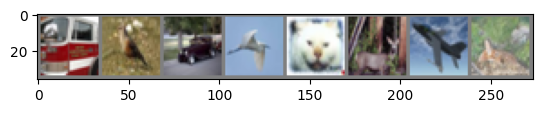

In [2]:
# hyper-parameters
n_epochs = 2
batchsize = 8
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5,), (0.5,) ) ] ) # each image is 3D (c * h * w)
# 0 and 1 ==> -1 and 1: (0 - 0.5)/0.5 = -1, (1 - 0.5)/0.5 = 1

# load CIFAR10
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def showimgs(img):                              # size/dim of each image: [c=3, height, weight]
    img = img * 0.5 + 0.5 # unnormalize
    npimg = img.numpy()   # this is not necessary
    npimg = np.transpose(npimg, (1, 2, 0))      # [h, w, c=3]
    plt.imshow(npimg)                           # ignoring any dimension>2
    plt.show()

images, labels = next(iter(train_loader))
print([classes[i] for i in labels ])
print("calling our defined showimgs():")
showimgs(torchvision.utils.make_grid(images))

#### two other (simpler) ways w/o defining a user function (just use plt.imshow() directly)

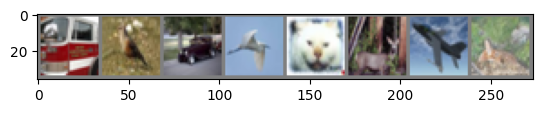

In [3]:
# 1. imshow - np.transpose()
plt.imshow( np.transpose(torchvision.utils.make_grid(images)*0.5+0.5, (1,2,0)) )

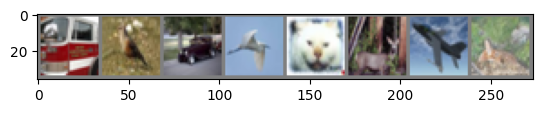

In [4]:
# 2. imshow - tensor.permute()
plt.imshow(  (torchvision.utils.make_grid(images)*0.5+0.5).permute(1,2,0)  )

## Define a CNN

In [5]:
# first conv layer: output channels=6, kernel size=5
# max pooling: 2 x 2
# second conv layer: output channels=16, kernel size=5

class ConvNet(nn.Module):
    def __init__(self, n_classes=10, input_size=32):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1
                                        # 32x32 --> 28x28 : ((H_or_W - k) + 2P)/S + 1
        self.pool = nn.MaxPool2d(2, 2)  # [6x] 14x14 (28/2)
        self.conv2 = nn.Conv2d(6, 16, 5)# [16x] 10x10
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # pooling by 2x (see below), 16 x [ ((input_size-4)//2 -4)//2 ] ^ 2
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # conv layers:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # fc layers:
        x = x.view(-1, 16 * 5 * 5) # -1: batch size. can also use reshape().
        # a smarter alternative: x.view(x.size(0), -1), in which '-1' is no longer batch size but the feature size, and x.size(0) gives the batch size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Let's try to define a ConvNet2 using nn.Sequential()!

In [6]:
# TODO: ConvNet2
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv_block1 = nn.Sequential(
          nn.Conv2d(3, 6, 5), # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1
                              # 32x32 --> 28x28 : ((H_or_W - k) + 2P)/S + 1
          nn.ReLU(),
          nn.MaxPool2d(2, 2)  # [6x] 14x14 (28/2)
        )

        self.conv_block2 = nn.Sequential(
          nn.Conv2d(6, 16, 5), # [16x] 10x10
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
        )

        flattened_size = 16 * (((input_size-4)//2 -4)//2)  ** 2

        self.fc_layers = nn.Sequential(
          nn.Linear(flattened_size, 120), # see below: pooling by 2x
          nn.Linear(120, 84),
          nn.Linear(84, 10)
        )

    def forward(self, x):
        # conv layers:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        # fc layers:
        x = x.view(x.size(0), -1) #or: x = x.view(-1, 16 * 5 * 5)
        x = self.fc_layers(x)
        return x


In [7]:
# train the CNN
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

begin = time.time()

n_total_steps = len(train_loader)
n_correct = 0
n_samples = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(axis=1) # torch.max(outputs, 1)
        n_correct += (preds==labels).sum()
        n_samples += labels.size(0) #batchsize

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Step {i+1}/{n_total_steps},\
                Loss: {loss.item():.4f}, Acc: {n_correct/n_samples:.3f}')

print('Training is Done! :)')

time_elapsed = time.time() - begin
print('Training has taken {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))


Epoch 1/2, Step 2000/6250,                Loss: 1.8565, Acc: 0.347
Epoch 1/2, Step 4000/6250,                Loss: 1.8117, Acc: 0.402
Epoch 1/2, Step 6000/6250,                Loss: 1.2461, Acc: 0.435
Epoch 2/2, Step 2000/6250,                Loss: 1.3142, Acc: 0.461
Epoch 2/2, Step 4000/6250,                Loss: 1.5797, Acc: 0.479
Epoch 2/2, Step 6000/6250,                Loss: 0.9785, Acc: 0.492
Training is Done! :)
Training has taken 1m 38s


In [8]:
# validation/test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0] * 10
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(axis=1) # torch.max(outputs, 1)
        n_correct += (preds==labels).sum()
        n_samples += labels.size(0) #batchsize

        for i in range(batchsize):
            label = labels[i]
            pred = preds[i]
            if (pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    # loop ends, got all stats

    acc = 100 * n_correct / n_samples
    print(f'Overall accuracy : {acc} %')

    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy for class {i} ({classes[i]}): {acc} %')

Overall accuracy : 55.75 %
Accuracy for class 0 (plane): 67.4 %
Accuracy for class 1 (car): 70.3 %
Accuracy for class 2 (bird): 32.3 %
Accuracy for class 3 (cat): 57.6 %
Accuracy for class 4 (deer): 33.6 %
Accuracy for class 5 (dog): 31.6 %
Accuracy for class 6 (frog): 61.3 %
Accuracy for class 7 (horse): 70.2 %
Accuracy for class 8 (ship): 69.4 %
Accuracy for class 9 (truck): 63.8 %
